# Palmer Penguins

This blog post takes data collected about three species of penguin in Antarctica and creates a predictive model of species based on the island that the penguin was found on and the penguins culmen length and depth. To begin, the data is cleaned and then explored using plots and aggregations. This allows us to have some idea of which variables will likely be good predictors of species, our target variable. Once I had narrowed down the predictor variables, I trained models on all possible combinations of the variables that we had and chose the top two best scores. I tried out a few other models, a Random Forest and a Support Vector Machine, in addition to the initial Logistic Regression model. After playing around with these models a little bit to increase training accuracy, I ended up with a Random Forest with training accuracy 100%. Finally I evaluated my model using the test data and ended up with a final accuracy of 100% on the test data. 

In [48]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np 
from matplotlib import pyplot as plt


plt.style.use('seaborn-v0_8-whitegrid')

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

The following code processes our data set into a form that we are able to use. It gets rid of the columns that won't be helpful in prediction (the ID, date the sample was collected, name of the study, comments etc.) and drops rows with any values that are not in the correct form (`na` or "."). 

We transform the species data from strings to numbers using `LabelEncoder()`. Our machine learning models can only understand numbers so we switch the species into an encoding of numbers, in this case between 0 and 2. 

Finally, we take the data frame (not including the variable that we are predicting, species) and call `pd.get_dummies`. This changes any non-numerical values into dummy or indicator values that can be used in our training. For instance, the `Sex` variable is turned into `Sex_FEMALE` and `Sex_MALE`, each if which has a true or false value (0 or 1). 

In [79]:
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

### EXPLORE

<Axes: xlabel='Body Mass (g)', ylabel='Flipper Length (mm)'>

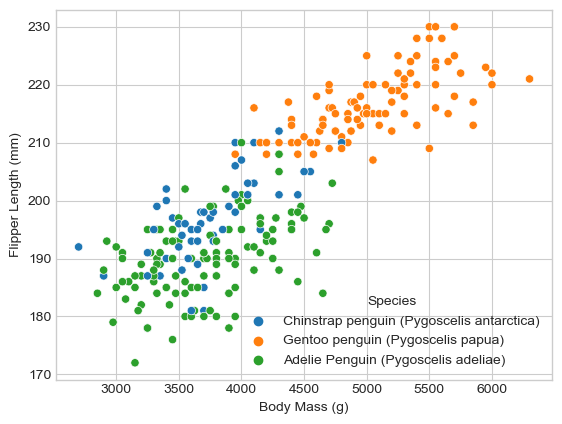

In [4]:
sns.scatterplot(data = train, x = 'Body Mass (g)', y = 'Flipper Length (mm)', hue = 'Species')

This plot shows the `Body Mass` vs. `Flipper Length` by species. It appears that the Gentoo penguin has a much larger body mass and longer flipper length than the other two species. However, there is not as much of a distinction between the Chinstrap and Adelie penguins. It seems that the Flipper Length is what distinguishes the Gentoo penguins from the other two species, as the Body Mass overlaps more between the three. This visualization indicates that flipper length may be a helpful variable in predicting species. 

<Axes: xlabel='Island', ylabel='count'>

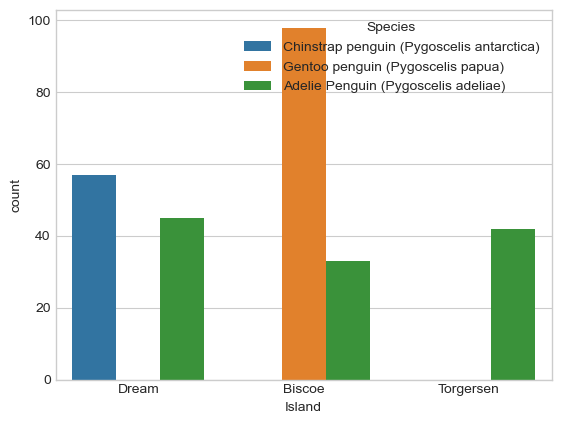

In [5]:
sns.countplot(train, x="Island", hue="Species")

This graph shows the distribution of penguins on the three islands. It appears that Adelie penguins are found on all three islands, and are the only species of penguins found on Torgsen. Chinstrap penguins are only found on Dream and Gentoo penguins are only found on Biscoe Island. Based on this visual, it appears that island may be a good variable to use when predicting penguin species. 

<Axes: xlabel='Culmen Length (mm)', ylabel='Culmen Depth (mm)'>

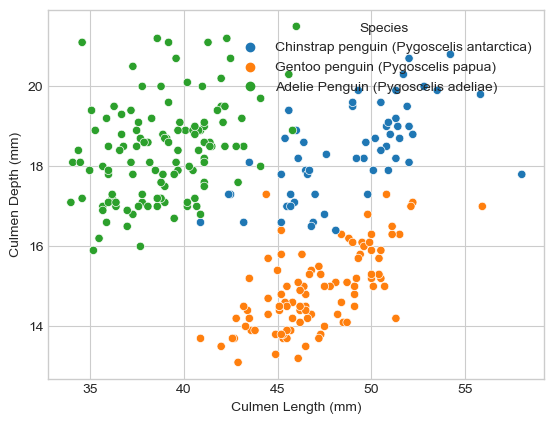

In [6]:
sns.scatterplot(data=train, x="Culmen Length (mm)", y="Culmen Depth (mm)", hue="Species")

This visualization shows the distribution of penguins according to their `Culmen Length` and `Culmen Depth`. As seen on the graph, the penguins are grouped into distinct groups by species, indicating that the culmen measurements will be good variables when predicting penguin species. 

In [7]:
train.groupby("Species")["Clutch Completion"].value_counts()

Species                                    Clutch Completion
Adelie Penguin (Pygoscelis adeliae)        Yes                  108
                                           No                    12
Chinstrap penguin (Pygoscelis antarctica)  Yes                   47
                                           No                    10
Gentoo penguin (Pygoscelis papua)          Yes                   90
                                           No                     8
Name: count, dtype: int64

This table shows that each species has a similar proportion of `Clutch Completions`, indicating that it would not be a helpful variable in predicting penguin species. 

In [8]:
train.groupby('Species')[["Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]].aggregate('mean')

,Delta 15 N (o/oo),Delta 13 C (o/oo)
Species,,
Adelie Penguin (Pygoscelis adeliae),8.861824,-25.796897
Chinstrap penguin (Pygoscelis antarctica),9.331004,-24.553401
Gentoo penguin (Pygoscelis papua),8.247341,-26.149389


This table shows the mean `Delta 15 N (o/oo)` and the mean `Delta 13 C (o/oo)` for each species and shows that they are similar across all three, so neither of these values will likely make a good predictor variable. 

### Choose Features

After looking at graphs and tables of the variables included in this data set, the most likely to train an accurate predictive model seem to be `Sex`, `Island`, `Culmen Length (mm)`, `Culmen Depth (mm)` and `Body Mass (g)`. I trained a logistic regression model on each to which score the highest out of all the possible combinations. 

In [42]:
from itertools import combinations

all_qual_cols = ["Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', "Body Mass (g)"]

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    print(cols)
    LR = LogisticRegression(max_iter = 5000)
    LR.fit(X_train[cols], y_train)
    print(LR.score(X_train[cols], y_train))
    

['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']
0.9921875
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Body Mass (g)']
0.98046875
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Body Mass (g)']
0.77734375
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']
0.99609375
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Body Mass (g)']
0.9765625
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Depth (mm)', 'Body Mass (g)']
0.8359375


Out of these variables, the best models are the model using columns `Sex`, `Culmen Length (mm)` and `Culmen Depth (mm)` with a score of 0.992 and the model using `Island`, `Culmen Length (mm)` and `Culmen Depth (mm)`, with a score of 0.996.  

### MODEL

In [53]:
cols = ["Culmen Depth (mm)", "Culmen Length (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]


Now that I know that this combination yields the highest scoring logistic regression models, I am going to try to improve the training accuracy by using a few other models, and I will use cross validation for each to prevent overfitting. 

##### Logistic Regression

In [56]:
from sklearn.model_selection import cross_val_score

LR = LogisticRegression(max_iter = 5000)
LR.fit(X_train[cols], y_train)
print(cross_val_score(LR, X_train[cols], y_train, cv = 5).mean())

0.9843891402714933


##### Support Vector Machine

In [55]:
from sklearn.svm import SVC


gamma = 10.0**np.arange(-4, 4)

for i in gamma:
    SVM = SVC(gamma = i)
    print('gamma = ', i)
    SVM.fit(X_train[cols], y_train)
    print(cross_val_score(SVM, X_train[cols], y_train, cv = 5).mean())

gamma =  0.0001
0.7266214177978884
gamma =  0.001
0.9217948717948717
gamma =  0.01
0.9648567119155353
gamma =  0.1
0.9687782805429863
gamma =  1.0
0.9610105580693815
gamma =  10.0
0.7578431372549019
gamma =  100.0
0.4530920060331825
gamma =  1000.0
0.42971342383107086


##### Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
max_depth = np.arange(5, 15)

for i in max_depth:
    print("max_depth: ", i)
    RF = RandomForestClassifier(max_depth = i)
    RF.fit(X_train[cols], y_train)
    print(cross_val_score(RF, X_train[cols], y_train, cv = 5).mean())


max_depth:  5
0.9843891402714933
max_depth:  6
0.9765460030165911
max_depth:  7
0.9804675716440423
max_depth:  8
0.9804675716440423
max_depth:  9
0.9804675716440423
max_depth:  10
0.9804675716440423
max_depth:  11
0.9804675716440423
max_depth:  12
0.9804675716440423
max_depth:  13
0.9843891402714933
max_depth:  14
0.9766214177978885


Based on these scores, the model that most accurately predicts penguin species is one of three: 

The Logistic Regression Model with a cross-val score of 0.984,
the Support Vector Machine model with a gamma values of 0.1 and a cross-val score of 0.969, and 
the Random Forest Classifier with a max-depth of 13 and a cross-val score of 0.984. 

Based off of this information, I decided to train both the logistic regression model and the random forest classifier to determine which to use. 

In [68]:
max_depth = 13
RF = RandomForestClassifier()
RF.fit(X_train[cols], y_train)
print(RF.score(X_train[cols], y_train))


1.0


In [63]:
LR = LogisticRegression(max_iter = 1000)
LR.fit(X_train[cols], y_train)
print(RF.score(X_train[cols], y_train))

1.0


Both of these models have a training accuracy of 100%, so I decided to go with the Random Forest Classifier, although both appear to be equally as effective. 


### EVALUATE

Now that we have our trained model, with an accuracy of 1.0 on the training data, it is time to see how well it performs on testing data. 

In [73]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
RF.score(X_test[cols], y_test)

1.0

Our model is 100% accurate on the test data. 

To see more specifcially how our model classified these penguins, I will plot the decision regions using the following function. 

##### Decision Regions

In [74]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

First I am plotting the decision regions of the training data. 

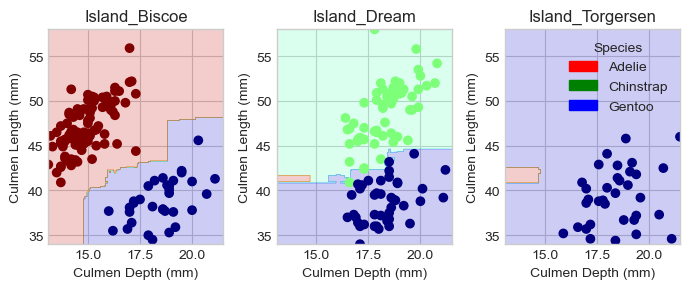

In [75]:
plot_regions(RF, X_train[cols], y_train)

And now the testing data

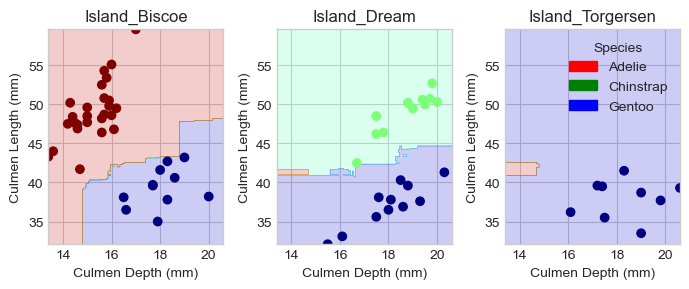

In [77]:
plot_regions(RF, X_test[cols], y_test)

It appears that the combination of understanding which islands certain species live on, in combination with knowing the dimensions of the penguins culmen makes a very effective prediction model. 

##### Confusion Matrix

In [78]:
from sklearn.metrics import confusion_matrix

y_test_pred = RF.predict(X_test[cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

Seeing as our model has 100% accuracy, the confusion matrix is not very informative for us. However, it does show us how the test data is split by species. 

### Discussion

This Blog Post documents the process of downloading a data set, exploring the data, training a model and evaluating that model. I was able to determine which variables would be best in predicting penguin species by first creating tables and plots to see the distribution of each variable, and then by brute force training Logistic Regression models on combinations of columns that I thought may be most predictive. After choosing `Island`, `Culmen Length (mm)` and `Culmen Depth (mm)` I trained different types of models (Logistic Regression, Support Vector Machine and Random Forest with different parameters) before ending up with a 100% training accuracy Random Forest model with a `max_depth` of 13. This model also yielded 100% test accuracy. In completing this Blog Post I learned about the steps and est practices of training a model using the existing frameworks and how to tweak models to improve their accuracy. 